---
title: "MicroGrad from Scratch with Andrej Karpathy's tutorial"
author: "Jax Bulbrook"
date: "2023-07-25"
categories: [100-papers]
---

I want to learn how Transformers work in depth, but I need a bit of background first. I am going to do all of the tutorials on Andrej Karpathy's channel, starting with [this micrograd from scratch one](https://www.youtube.com/watch?v=VMj-3S1tku0). That should give me enough background to understand his latest GPT from Scratch tutorial!

In [8]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''): #the data is the value, we need children to store the children passed into functions like add and mult, and op to show the operations that came up with those children.
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other),"+")
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),"*")
        return out

In [10]:
a = Value(1.5,label='a')
b = Value(-5.5,label='b')
c = Value(0.2,label='c')
a*b,a+b

(Value(data=-8.25), Value(data=-4.0))

In [24]:
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.2,label='f')
L = d*f; L.label = 'L' # the loss function L

In [19]:
d._prev

{Value(data=-8.25), Value(data=0.2)}

In [20]:
d._op

'+'

# Now we want a way to visualize the tree, since there will eventually be many values in the tree.

In [21]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

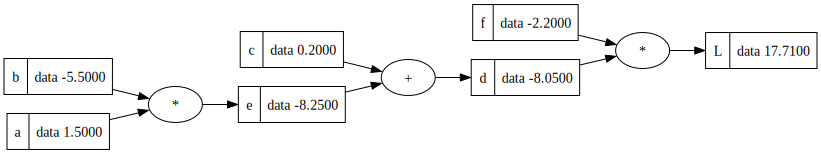

In [25]:
draw_dot(L)